Importing Necessary Libraries

In [1]:
import wfdb
import pandas as pd
import numpy as np

Setting Dataset path and Record

In [2]:
dataset_path = "dataset/mit-bih/"
patient_number = "100"
full_path = dataset_path+patient_number

Getting Record Features and Annotations

In [3]:
patient_record = wfdb.rdsamp(full_path)
record = wfdb.rdrecord(full_path)
anno = wfdb.rdann(full_path, 'atr')

Plotting ECG Signal

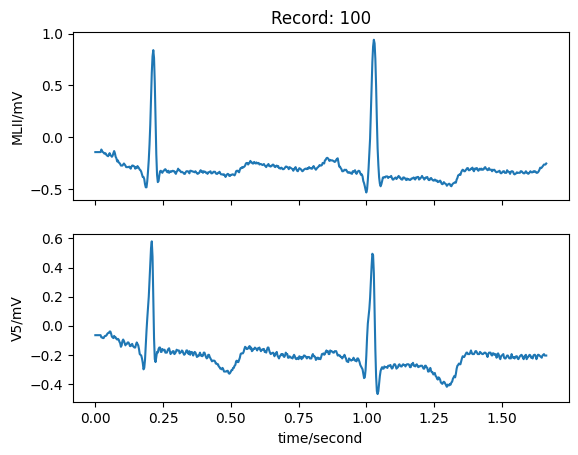

In [4]:
plot_record = wfdb.rdrecord(full_path, sampto=600)

wfdb.plot_wfdb(plot_record) # plots the ECG

Printing all Labels of Dataset

In [5]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

Printing Sample Numbers with Abnormal Labels

In [6]:
for i in range(len(anno.symbol)):
    sample = anno.sample[i]
    symbol = anno.symbol[i]
    if symbol != 'N':
        print(f"Sample: {sample}, Symbol: {symbol}")

Sample: 18, Symbol: +
Sample: 2044, Symbol: A
Sample: 66792, Symbol: A
Sample: 74986, Symbol: A
Sample: 99579, Symbol: A
Sample: 128085, Symbol: A
Sample: 170719, Symbol: A
Sample: 279576, Symbol: A
Sample: 305709, Symbol: A
Sample: 307745, Symbol: A
Sample: 312825, Symbol: A
Sample: 317785, Symbol: A
Sample: 319223, Symbol: A
Sample: 346804, Symbol: A
Sample: 351481, Symbol: A
Sample: 377081, Symbol: A
Sample: 397335, Symbol: A
Sample: 421994, Symbol: A
Sample: 422818, Symbol: A
Sample: 433841, Symbol: A
Sample: 436149, Symbol: A
Sample: 442623, Symbol: A
Sample: 444705, Symbol: A
Sample: 454651, Symbol: A
Sample: 458168, Symbol: A
Sample: 496712, Symbol: A
Sample: 520982, Symbol: A
Sample: 546792, Symbol: V
Sample: 562812, Symbol: A
Sample: 566259, Symbol: A
Sample: 567379, Symbol: A
Sample: 574429, Symbol: A
Sample: 579448, Symbol: A
Sample: 593068, Symbol: A
Sample: 629171, Symbol: A


In [7]:
from scipy.signal import find_peaks
from sklearn import preprocessing

Printing R-Peaks of Signal

In [8]:
signals0 = preprocessing.scale(np.nan_to_num(record.p_signal[:,0])).tolist()
signals1 = preprocessing.scale(np.nan_to_num(record.p_signal[:,1])).tolist()
from scipy.signal import find_peaks
peaks, _ = find_peaks(signals0, distance=150)

print(peaks)

[    77    370    663 ... 649485 649734 649991]


In [9]:
# Define the window size and overlap
window_size = 100  # Adjust to your desired window size
overlap = 50  # Adjust to control the overlap between windows

# Create a list to store the segmented R-peaks
segmented_r_peaks = []

for i in range(0, len(peaks) - window_size, overlap):
    segment = peaks[i:i + window_size]
    segmented_r_peaks.append(segment)



In [10]:
s = segmented_r_peaks[0][0]
label = anno.symbol[s]

print(label)

N


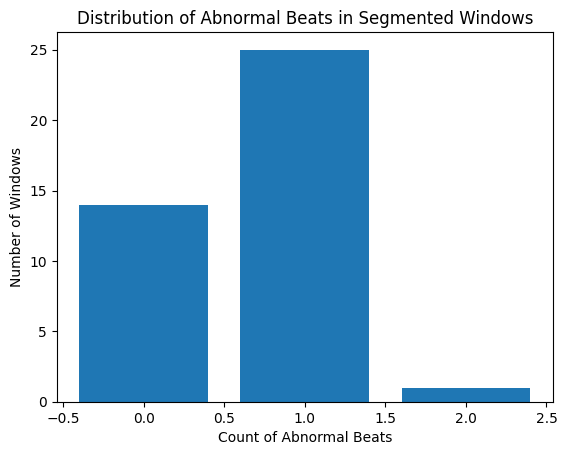

In [33]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt

# Load MIT-BIH dataset and annotations
record = wfdb.rdrecord(full_path, sampto=2000)  # Adjust the record and sample range as needed
annotation = wfdb.rdann(full_path, 'atr', sampto=2000)  # Adjust annotation file name and sample range

# Define window size and step
window_size = 200  # Adjust the window size as needed
step = 50  # Adjust the step size as needed

# Initialize lists to store the count of abnormal beats in each window
abnormal_beat_counts = []

# Iterate through the ECG signal in windows
for i in range(0, len(record.p_signal), step):
    start = i
    end = min(i + window_size, len(record.p_signal))
    
    # Count abnormal beats in the current window
    window_abnormal_beats = sum([1 for ann in annotation.sample if start <= ann < end])
    
    abnormal_beat_counts.append(window_abnormal_beats)

# Plot a histogram to visualize the distribution
plt.hist(abnormal_beat_counts, bins=range(0, max(abnormal_beat_counts) + 2), align='left', rwidth=0.8)
plt.xlabel('Count of Abnormal Beats')
plt.ylabel('Number of Windows')
plt.title('Distribution of Abnormal Beats in Segmented Windows')
plt.show()


In [37]:
from src import hrv 

# Create lists to store HRV features and labels
hrv_features_list = []
segment_labels = []

# Assuming you have annotations indicating normal (N) and abnormal (A) beats
# You should modify this based on your dataset's annotation format

for segment in segmented_r_peaks:
    rr_intervals = np.diff(segment)  # Calculate RR intervals from R-peak indices
    
    # Calculate HRV features for each segment using your HRV calculation function
    hrv_features = hrv.calculate_hrv_features(rr_intervals)
    
    # Obtain the label for the segment (e.g., 'N' for normal, 'A' for abnormal)
    # This depends on your dataset's annotation format
    for s in segment:
        try:
            label = anno.symbol[segment[0]]
        except:
            print('error')
    
    hrv_features_list.append(hrv_features)
    segment_labels.append(label)
    break


In [11]:
from wfdb import rdann
from src import hrv, segment_peaks

# Define the input size and window size
input_size = 100  # You can adjust this to your desired window size
window_size = 5  # Adjust the window size for segmenting R-peaks

# Create lists to store segmented data, HRV features, and labels
segmented_data = []
segmented_hrv_features = []
segmented_labels = []

# Loop through each R-peak to segment and process the data
for peak in peaks:
    start, end = peak - input_size // 2, peak + input_size // 2

    # Check if the segment is within the signal boundaries
    if start >= 0 and end < len(signals0):
        # Extract the ECG data for the segment
        segment_data0 = signals0[start:end]
        segment_data1 = signals1[start:end]

        # Segment the R-peaks using a window of 'window_size'
        segmented_r_peaks = peaks[peak >= start][peak <= end]

        # Calculate HRV features for each segment
        hrv_features = hrv.calculate_hrv_features(segmented_r_peaks)

        # Read annotations for the segment
        ann = rdann(full_path, extension='atr', sampfrom=start, sampto=end, return_label_elements=['symbol'])
        if ann is not None and len(ann.symbol) == 1 and ann.symbol[0] in ['N', 'V', '/', 'A', 'F', '~']:
            segment_annotation = ann.symbol[0]

            # Append the segment data, HRV features, and label to the respective lists
            segmented_data.append((segment_data0, segment_data1))
            segmented_hrv_features.append(hrv_features)
            segmented_labels.append(segment_annotation)

# Now you have segmented data, corresponding HRV features, and labels


[[100, 200, 300], [400, 500, 600], [700, 800, 900]]


c:\Users\91916\AppData\Local\Programs\Python\Python38-32\lib\site-packages\hrvanalysis\extract_features.py:111: RuntimeWarning: divide by zero encountered in divide
  pnni_50 = 100 * nni_50 / length_int
c:\Users\91916\AppData\Local\Programs\Python\Python38-32\lib\site-packages\hrvanalysis\extract_features.py:113: RuntimeWarning: divide by zero encountered in divide
  pnni_20 = 100 * nni_20 / length_int


MemoryError: Unable to allocate 820. MiB for an array with shape (1, 1, 26243, 4096) and data type float64

In [10]:
print(segment_data0)
print(segment_data1)

[0.47256311227815057, 0.47256311227815057, 0.4466831337611785, 0.5760830263460385, 0.49844309079512256, 0.3690431982102626, 0.16200337007448637, 0.006723498972654513, 0.03260347748962654, -0.04503645806128954, 0.006723498972654513, -0.019156479544317512, -0.14855637212917763, -0.25207628619706546, -0.4073561572988976, -0.45911611433284166, -0.4849960928498137, -0.4332361358158696, -0.32971622174798154, -0.32971622174798154, -0.4073561572988976, -0.4849960928498137, -0.45911611433284166, -0.3814761787819256, -0.3814761787819256, -0.4332361358158696, -0.4073561572988976, -0.5367560498837575, -0.4332361358158696, -0.45911611433284166, -0.4073561572988976, -0.4073561572988976, -0.4073561572988976, -0.45911611433284166, -0.5626360284007295, -0.6661559424686175, -0.8214358135704497, -1.1061155772571418, -1.1578755342910858, -1.3649153624268615, -1.4943152550117216, -1.5978351690796095, -1.3907953409438334, -0.8731957706043935, -0.22619630768009344, 0.6019630048630106, 1.9218419092285828, 3.5

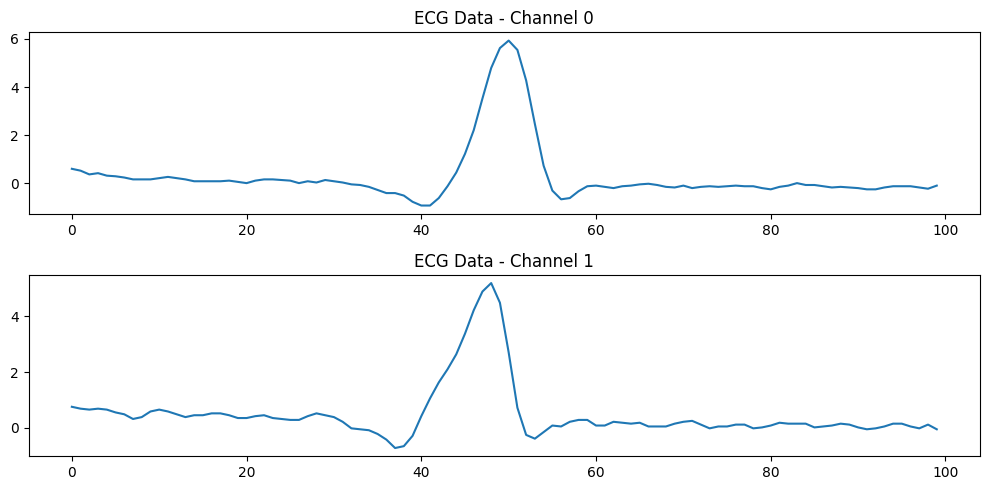

In [11]:
import matplotlib.pyplot as plt

# Loop through each segment of segmented data and create a plot
for segment_data0, segment_data1 in segmented_data:
    # Create a time array based on the segment length
    time = range(len(segment_data0))  # Assuming the data is sampled uniformly

    # Create a figure with two subplots (one for each channel)
    plt.figure(figsize=(10, 5))
    
    # Plot the ECG data from channel 0
    plt.subplot(2, 1, 1)
    plt.plot(time, segment_data0)
    plt.title('ECG Data - Channel 0')
    
    # Plot the ECG data from channel 1
    plt.subplot(2, 1, 2)
    plt.plot(time, segment_data1)
    plt.title('ECG Data - Channel 1')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

    break

In [2]:

pip install --upgrade tensorflow keras